# Varianti virali

Frequenze delle varianti virali in Italia.

> Max Pierini

Fonte dati: [GISAID-NextStrain-neherlab](https://nextstrain.org/groups/neherlab/ncov/italy?c=pangolin_lineage&d=frequencies&f_country=Italy&lang=it&p=full&r=division)

***

In [1]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

In [2]:
def get_variants(country="italy", save=False):
    
    freq_url = f"https://nextstrain.org/charon/getDataset?prefix=/groups/neherlab/ncov/{country}&type=tip-frequencies"
    freq_req = requests.get(freq_url)
    freq_json = freq_req.json()
    
    tot_url = f"https://nextstrain.org/charon/getDataset?prefix=/groups/neherlab/ncov/{country}"
    tot_req = requests.get(tot_url)
    tot_json = tot_req.json()
    if save:
        import json
        with open('nextrains.json', 'w') as f:
            json.dump(tot_json, f)
    tree = tot_json['tree']
    
    index = []
    for pivot in freq_json['pivots']:
        fraction = pivot - int(pivot)
        date = pd.to_datetime(int(pivot), format='%Y') + pd.Timedelta(days=fraction*365)
        index.append(date.date())
    index = np.array(index)
    
    RESULTS = {
        'date': [],
        'name': [],
        #'pangolin_lineage': [], 
        'clade_membership': [],
        'frequency': [],
    }

    
    def loop_tree(tree):

        name = tree['name']
        frequencies = [0 for _ in range(index.size)]
        if name in freq_json:
            frequencies = freq_json[name]['frequencies']
        else:
            pass
            #print(name, 'not in frequencies')
        
        #pangolin_lineage = 'None'
        #if 'node_attrs' in tree:
        #    node_attrs = tree['node_attrs']
        #    if 'pangolin_lineage' in node_attrs:
        #        pangolin_lineage = node_attrs['pangolin_lineage']['value']
        #pangolin_lineage = 'None'
        clade_membership = 'None'
        if 'node_attrs' in tree:
            node_attrs = tree['node_attrs']
            if 'subclade_membership' in node_attrs:
                clade_membership = node_attrs['subclade_membership']['value']

        try:
            for i, frequency in enumerate(frequencies):
                RESULTS['date'].append(index[i])
                RESULTS['name'].append(name)
                #RESULTS['pangolin_lineage'].append(pangolin_lineage)
                RESULTS['clade_membership'].append(clade_membership)
                RESULTS['frequency'].append(frequency)
        except Exception as err:
            print(name)
            return

        if isinstance(tree, dict):
            if 'children' in tree:
                for child in tree['children']:
                    loop_tree(child)

                    
    loop_tree(tree)
    
    return pd.DataFrame(RESULTS)

In [3]:
df = get_variants()
df['date'] = pd.to_datetime(df.date)

In [4]:
df_sum = df.groupby(['date', 'clade_membership']).sum().reset_index()

In [5]:
df_sum_pivot = df_sum.pivot(
    index='date', columns='clade_membership', values='frequency'
)

In [6]:
df_sum_pivot['_SUM_'] = df_sum_pivot.sum(axis=1)

In [7]:
for col in df_sum_pivot.columns[:-2]:
    df_sum_pivot.loc[:,col] =  df_sum_pivot.loc[:,col] / df_sum_pivot['_SUM_']

In [8]:
df_sum_pivot = df_sum_pivot.iloc[:,:-2]

In [9]:
df_sum_latest = df_sum[df_sum.date == df_sum.date.max()]

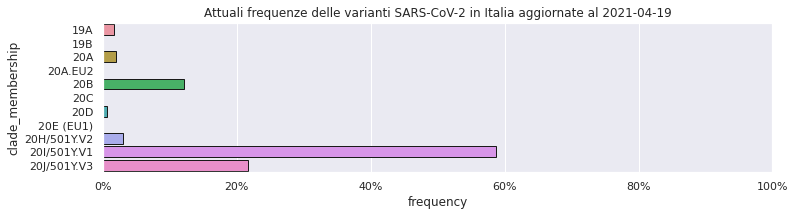

In [10]:
df_sum_latest_0 = df_sum_latest[df_sum_latest.frequency>0]

fig, ax = plt.subplots(figsize=(12, df_sum_latest_0.clade_membership.size*.25))
sns.barplot(
    data=df_sum_latest_0,
    x='frequency', y='clade_membership',
    ec='k',
    ax=ax
)
ax.set(
    title=f"Attuali frequenze delle varianti SARS-CoV-2 in Italia aggiornate al {df_sum_latest_0.date.max().date()}",
    xlim=(0, 1)
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

In [11]:
_ = """xlo = pd.to_datetime(df_sum.date.unique()[-10])
flo = .05

df_sum_pivot_small = df_sum[
    (df_sum.frequency>flo)&
    (df_sum.date>=xlo)
].pivot(
    index='date', columns='clade_membership', values='frequency'
)

df_sum_pivot_small.index = pd.to_datetime(df_sum_pivot_small.index)"""

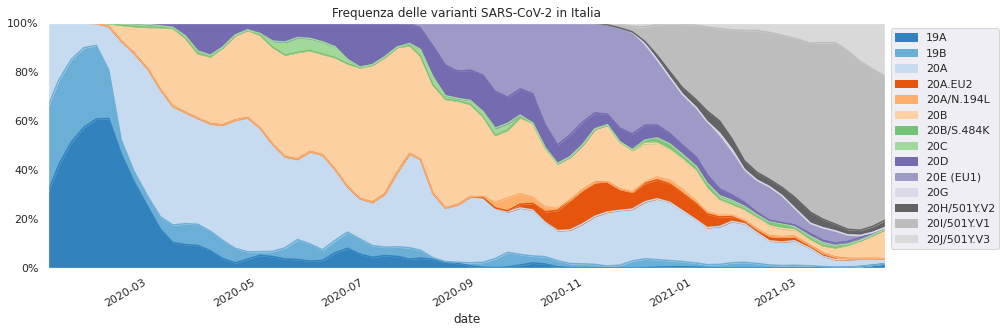

In [12]:
ax = df_sum_pivot.plot(
    kind='area', figsize=(15, 5),
    title=f'Frequenza delle varianti SARS-CoV-2 in Italia',
    ylim=(0, 1),
    xlim=(df_sum_pivot.index.min(), df_sum_pivot.index.max()),
    colormap='tab20c'
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

In [13]:
df_sum_pivot1 = df_sum_pivot.copy(deep=True)
df_sum_pivot1.index = df_sum_pivot1.index.strftime('%d %b %Y')

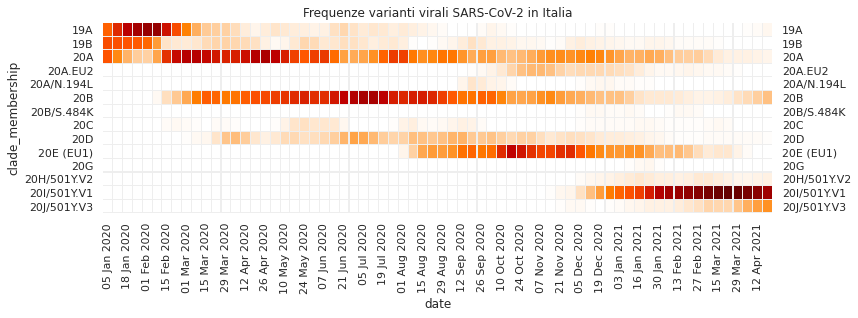

In [14]:
fig, ax = plt.subplots(figsize=(12, df_sum_pivot.columns.size*.25))
sns.heatmap(
    df_sum_pivot1.T, ax=ax,
    linewidths=.1,
    linecolor='#eeeeee',
    vmin=0, vmax=1,
    yticklabels=True,
    #cmap='binary',
    cmap='gist_heat_r',
    cbar=False
)
ax.set(
    title='Frequenze varianti virali SARS-CoV-2 in Italia'
)
ax.tick_params(axis='y', which='both', labelleft='on', labelright='on', rotation=0)
plt.show()